In [11]:
import load_mnist_data

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import numpy as np
import torch.backends.cudnn as cudnn
import random
import os
import sys
from torch.autograd import Function

import matplotlib.pyplot as plt

import data_visualization

In [85]:
class ReverseLayerF(Function):

    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None


class DANN(nn.Module):
    def __init__(self):
        super(DANN, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.ReLU(True),
            nn.Conv2d(64, 50, kernel_size=5),
            nn.BatchNorm2d(50),
            nn.Dropout2d(),
            nn.MaxPool2d(2),
            nn.ReLU(True)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(50, 64, 5, stride=2, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 3, 5, stride=2, output_padding=1),
            nn.InstanceNorm2d(3),
            nn.ReLU(inplace=True),

            nn.Tanh()
        )
    
        self.classifier = nn.Sequential(
            nn.Linear(50 * 4 * 4, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, 10),
        )

        self.domain_classifier = nn.Sequential(
            nn.Linear(50 * 4* 4, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, 2),
        )
        
    def forward(self, input_data, alpha):
            input_data = input_data.expand(input_data.data.shape[0], 3, 28, 28)
            feature = self.feature(input_data)

            reconstructed_data = self.decoder(feature)
            feature = feature.view(-1, 50 * 4 * 4)
            reverse_feature = ReverseLayerF.apply(feature, alpha)
            class_output = self.classifier(feature)
            domain_output = self.domain_classifier(reverse_feature)

            return class_output, domain_output, reconstructed_data

In [98]:
def train(source, target, net, criterion,criterion_construct, optimizer, use_cuda, epoch):
    net.train() # Sets the module in training mode.
    total = 0
    data_target_iter = iter(target)

    correct_source_label = 0
    correct_source_domain = 0
    correct_target_label = 0
    correct_target_domain = 0

    loss_min = 10000
    len_dataloader = min(len(source), len(target))

    for batch_idx, (source_inputs, source_label) in enumerate(source):
        batch_size = source_inputs.size(0)
        total += batch_size
        optimizer.zero_grad()

        # Set alpha with respect to epoch number
        p = float(batch_idx + epoch * len_dataloader) / (200 * len_dataloader)
        alpha = 2. / (1. + np.exp(-10 * p)) - 1

        # Specify the domain label and image label for Source
        source_label = source_label.type(torch.LongTensor)
        domain_label = torch.zeros(batch_size).long()

        if use_cuda: source_inputs, source_label, domain_label = source_inputs.cuda(), source_label.cuda(), domain_label.cuda()

        # Feed Source image into network
        source_inputs, source_label = Variable(source_inputs), Variable(source_label)
        class_output, domain_output, reconstruct_source = net(input_data=source_inputs, alpha=alpha)

        # Update the label classification accuracy and domain classification accuracy for Source image
        _, predicted = torch.max(class_output.data, 1)
        _, predicted = torch.max(domain_output.data, 1)
        correct_source_label += predicted.eq(source_label.data).cpu().sum().item()
        correct_source_domain += predicted.eq(domain_label.data).cpu().sum().item()

        # Calculate the loss of Source images
        loss_s_label = criterion(class_output, source_label)
        loss_s_domain = criterion(domain_output, domain_label)
        loss_construct_ss = criterion_construct(reconstruct_source, source_inputs)
        
        # Specify the domain label and image label for Target
        target_inputs, target_label = data_target_iter.next()
        domain_label = torch.ones(batch_size).long()
        if use_cuda: target_inputs, target_label, domain_label = target_inputs.cuda(), target_label.cuda(), domain_label.cuda()
        
        # Feed Target image into network
        target_inputs, target_label = Variable(target_inputs), Variable(target_label)
        class_output, domain_output, reconstruct_target = net(input_data=target_inputs, alpha=alpha)

        # Update the label classification accuracy and domain classification accuracy for Target image
        _, predicted = torch.max(class_output.data, 1)
        _, predicted = torch.max(domain_output.data, 1)
        correct_target_label += predicted.eq(target_label.data).cpu().sum().item()
        correct_target_domain += predicted.eq(domain_label.data).cpu().sum().item()

        # Calculate the loss of Target images
        loss_construct_tt = criterion_construct(reconstruct_target, target_inputs)
        loss_t_domain = criterion(domain_output, domain_label)

        # Measure the difference between reconstructed target images and reconstructed source images
        loss_construct_st = criterion_construct(reconstruct_target, reconstruct_source)

        loss = loss_s_label + loss_s_domain + loss_t_domain + loss_construct_tt + loss_construct_ss + loss_construct_st
        loss.backward()
        optimizer.step()

        if (loss < loss_min):
               loss_min = loss

               image_ss = reconstruct_source.data.cpu().detach().numpy()
               image_ts = reconstruct_target.data.cpu().detach().numpy()
               image_t =  target_inputs.data.cpu().detach().numpy()
               image_s =  source_inputs.data.cpu().detach().numpy()

    if (epoch % 5 == 0):
        print("e: %d, sl: %f, sd: %f, tl: %f, td: %f" % (epoch, correct_source_label/total, correct_source_domain/total, correct_target_label/total, correct_target_domain/total))

    return image_ss, image_ts, image_t, image_s


In [5]:
loader_source, loader_target = load_mnist_data.get_data_loader(1)

In [101]:
criterion = nn.CrossEntropyLoss()
criterion_construct = torch.nn.MSELoss()
net = DANN()
if (torch.cuda.is_available()):
    torch.cuda.manual_seed_all(42)
    cudnn.benchmark = True
    net.cuda()
    criterion = criterion.cuda()
    criterion_construct = criterion_construct.cuda()
    
optimizer = optim.Adam(net.parameters(), lr=0.001) 


e: 0, sl: 0.820000, sd: 0.766017, tl: 0.382800, td: 0.725283
e: 5, sl: 0.926683, sd: 0.719067, tl: 0.524417, td: 0.714217
e: 10, sl: 0.926133, sd: 0.690233, tl: 0.559533, td: 0.682900
e: 15, sl: 0.926417, sd: 0.669200, tl: 0.588367, td: 0.663233
e: 20, sl: 0.927583, sd: 0.657583, tl: 0.608200, td: 0.652350
e: 25, sl: 0.927700, sd: 0.644450, tl: 0.619933, td: 0.644183
e: 30, sl: 0.930050, sd: 0.641083, tl: 0.635167, td: 0.636050
e: 35, sl: 0.931283, sd: 0.643667, tl: 0.641283, td: 0.637533
e: 40, sl: 0.932750, sd: 0.637700, tl: 0.646383, td: 0.633233
e: 45, sl: 0.936700, sd: 0.631367, tl: 0.658450, td: 0.629217
e: 50, sl: 0.936167, sd: 0.630450, tl: 0.677133, td: 0.627600
e: 55, sl: 0.940133, sd: 0.632000, tl: 0.676550, td: 0.629983
e: 60, sl: 0.940733, sd: 0.630983, tl: 0.682083, td: 0.630983
e: 65, sl: 0.940167, sd: 0.631150, tl: 0.680517, td: 0.633617
e: 70, sl: 0.941000, sd: 0.626833, tl: 0.686900, td: 0.627300
e: 75, sl: 0.943267, sd: 0.631167, tl: 0.685950, td: 0.626900
e: 80, sl:

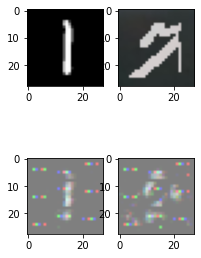

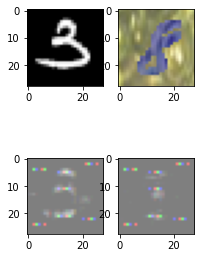

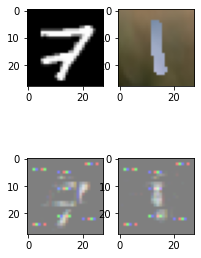

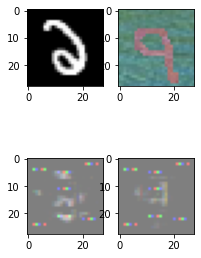

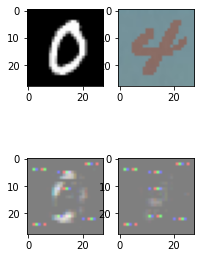

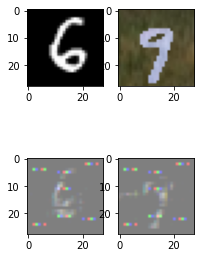

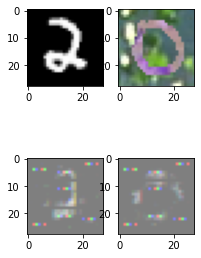

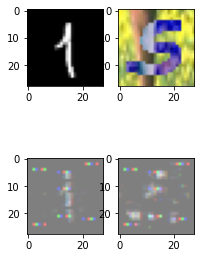

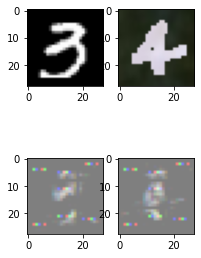

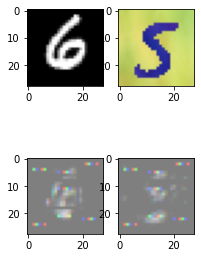

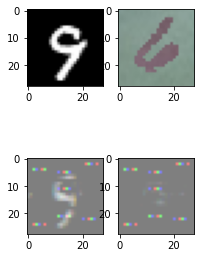

In [102]:
for epoch in range(0, 201):
    image_ss, image_ts, image_t, image_s = train(loader_source, loader_target, net, criterion, criterion_construct, optimizer, True, epoch) 
    index = 0
    if (epoch % 10 == 0):
        fig, axs = plt.subplots(nrows=2, ncols = 2, figsize=(3, 5))
        img = image_s[index].reshape(28,28,3)
        img = (img + 1) * 0.5

        img2 = image_t[index].reshape(28,28,3)
        img2 = (img2 + 1) * 0.5

        img3 = image_ss[index].reshape(28,28,3)
        img3 = (img3 + 1) * 0.5

        img4 = image_ts[index].reshape(28,28,3)
        img4 = (img4 + 1) * 0.5

        fig.savefig('./reconstruct/%d_img.png' % epoch)

In [110]:
def generate_image(net, source, target, epoches):
    data_target_iter = iter(target)
    len_dataloader = min(len(source), len(target))
    
    source_reconstrueted = []
    source_label_lst = []
    target_reconstructed = []
    target_label_lst = []
    for batch_idx, (source_inputs, source_label) in enumerate(source):
        optimizer.zero_grad()

        # Set alpha with respect to epoch number
        p = float(batch_idx + epoches * len_dataloader) / 100 / len_dataloader
        alpha = 2. / (1. + np.exp(-10 * p)) - 1

        # Specify the domain label and image label for Source
        source_label = source_label.type(torch.LongTensor)

        source_inputs, source_label = source_inputs.cuda(), source_label.cuda()

        # Feed Source image into network
        source_inputs, source_label = Variable(source_inputs), Variable(source_label)
        _, _, reconstruct_source = net(input_data=source_inputs, alpha=alpha)

        
        # Specify the domain label and image label for Target
        target_inputs, target_label = data_target_iter.next()
        target_inputs, target_label = target_inputs.cuda(), target_label.cuda()
        
        # Feed Target image into network
        target_inputs, target_label = Variable(target_inputs), Variable(target_label)
        _, _, reconstruct_target = net(input_data=target_inputs, alpha=alpha)

        source_reconstrueted.extend(reconstruct_source.data.cpu().detach().numpy())
        source_label_lst.extend(source_label.cpu().detach().numpy())
        target_reconstructed.extend(reconstruct_target.data.cpu().detach().numpy())
        target_label_lst.extend(source_label.cpu().detach().numpy())

    return np.array(source_reconstrueted), np.array(target_reconstructed), np.array(source_label_lst), np.array(target_label_lst)
    

In [111]:
source_reconstrueted, target_reconstructed, source_label, target_label = generate_image(net, loader_source, loader_target, 100)

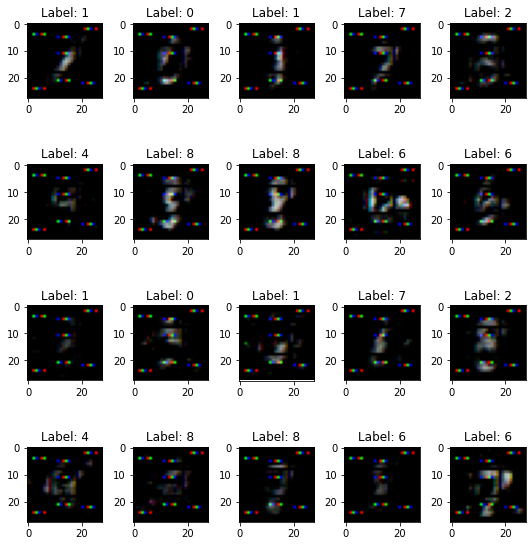

In [117]:
num_row = 4
num_col = 5
num = 10
images = source_reconstrueted[:num]
labels = source_label[:num]

fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    image = images[i - 10].reshape(28,28,3)
    ax.imshow(image, cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))


images = target_reconstructed[:num]
labels = target_label[:num]
for i in range(10,20):
    ax = axes[i//num_col, i%num_col]
    image = images[i - 10].reshape(28,28,3)
    ax.imshow(image, cmap='gray')
    ax.set_title('Label: {}'.format(labels[i - 10]))
plt.tight_layout()
plt.show()

In [ ]:
source_tranformed_data = data_visualization.tsne(source_reconstrueted, 3, 0.1, type = "mnist")

In [ ]:
data_visualization.plot_info(source_tranformed_data, source_label, 3)

In [ ]:
target_tranformed_data = data_visualization.tsne(source_reconstrueted, 3, 0.1, type = "mnist-m")

In [ ]:
data_visualization.plot_info(target_tranformed_data, target_label, 3)